# The Story Behind Germany's Rising Housing Prices
## _Uncovering Regional Disparities and Market Dynamics from 1964-2025_

## Executive Summary

### Key Findings

> **Dataset**: 21 German cities spanning **1964-2025** across three property types: apartments, single-family houses, and multi-family houses

#### The Big Picture
Using comprehensive housing price data for around 21 German cities, we uncover fascinating long-term developments in the German housing market. Our analysis reveals:

- **Convergence until 2010**: Housing prices across German cities followed a broadly similar trend until the early 2000s
- **Regional Divergence**: From 2010 onwards, price developments differ **dramatically** across cities
  - Some cities (Munich, Frankfurt, Hamburg) show exceptional growth
  - Others experience stagnation or decline
- **Property Type Differences**: Apartments and single-family houses outpace multi-family homes

#### Economic Drivers
Our comparison with macroeconomic indicators (GDP growth, interest rates, unemployment) reveals that:

1. Housing prices are **not** driven by economic growth alone  
2. **Low interest rates** and **declining unemployment** fuel strong price increases  
3. Recent price corrections show **high sensitivity** to financial conditions  
4. **Regional and structural differences** in the market are increasingly pronounced

> 🎯 **Context**: Germany's housing prices have steadily risen for decades, driven by urban demand, inflation, and interest rate shifts that make home ownership increasingly challenging for many.

## Our Audience & Use Cases

### **Urban Policy Analyst**
   - **Role**: City planning department (e.g., Berlin)
   - **Interests**: Housing affordability, inflation correlation, income-to-price ratios
   - **Use**: Informing housing policy and public strategy design

### **Real Estate Investor** 
   - **Role**: Private investor seeking long-term opportunities
   - **Interests**: Growth trends by city, property type performance, market timing
   - **Use**: Identifying high-potential markets for investment

### **Academic & Student Community**
   - **Role**: University researchers, data science enthusiasts
   - **Interests**: Data-driven storytelling, visualization techniques, real-world analytics
   - **Use**: Learning case study combining economics, visualization, and machine learning

In [44]:
# Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib.ticker import MultipleLocator, MaxNLocator
import plotly.graph_objects as go



In [10]:
#Read CSV

df = pd.read_excel("Data/GREIX_all_cities_data.xlsx")


display(df.head(10))

,Year,Quarter,City,Property_Type,Index,Price,Inflation
0,1963,1.0,Hamburg,Single-family house,NaN,1200.0,1
1,1963,1.0,Hamburg,Single-family house,NaN,400.0,0
2,1963,2.0,Hamburg,Single-family house,NaN,300.0,0
3,1963,2.0,Hamburg,Single-family house,NaN,1100.0,1
4,1963,3.0,Hamburg,Single-family house,NaN,400.0,0
5,1963,3.0,Hamburg,Single-family house,NaN,1200.0,1
6,1963,4.0,Hamburg,Single-family house,NaN,300.0,0
7,1963,4.0,Hamburg,Single-family house,NaN,900.0,1
8,1963,NaN,Hamburg,Single-family house,NaN,1100.0,1
9,1963,NaN,Hamburg,Single-family house,NaN,300.0,0


In [11]:
# Basic structure
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21058 entries, 0 to 21057
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           21058 non-null  int64  
 1   Quarter        15984 non-null  float64
 2   City           21058 non-null  object 
 3   Property_Type  21058 non-null  object 
 4   Index          20210 non-null  float64
 5   Price          18180 non-null  float64
 6   Inflation      21058 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 1.1+ MB


In [12]:
print("\nShape of dataset:", df.shape)




Shape of dataset: (21058, 7)


In [13]:
print("\nMissing values per column:\n", df.isna().sum())



Missing values per column:
 Year                0
Quarter          5074
City                0
Property_Type       0
Index             848
Price            2878
Inflation           0
dtype: int64


In [14]:
print("\nUnique cities:", df['City'].nunique())
df['City'].unique()


Unique cities: 23


array(['Hamburg', 'Berlin', 'GREIX', 'Cologne', 'Dortmund', 'Duisburg',
       'Munich', 'Duesseldorf', 'North Rhine-Westphalia', 'Wiesbaden',
       'Frankfurt', 'Muenster', 'Stuttgart', 'Dresden', 'Karlsruhe',
       'Chemnitz', 'Luebeck', 'Bonn', 'Erfurt', 'Kreis Mettmann',
       'Potsdam', 'Rhein-Erft-Kreis', 'Leipzig'], dtype=object)

In [15]:
# Count missing values per city for each relevant column
missing_by_city = (
    df.groupby("City")[["Price"]]
      .apply(lambda x: x.isna().sum())
      .sort_values(by="Price", ascending=False)
)

print("Missing values by City:")
print(missing_by_city)


Missing values by City:
                        Price
City                         
Berlin                   1622
Duisburg                  450
Cologne                   138
Erfurt                    134
Bonn                       78
Frankfurt                  72
Karlsruhe                  68
Wiesbaden                  68
Muenster                   66
Dortmund                   58
Chemnitz                   50
Hamburg                    46
Luebeck                    12
Potsdam                     8
Duesseldorf                 6
Dresden                     2
Leipzig                     0
GREIX                       0
Kreis Mettmann              0
North Rhine-Westphalia      0
Munich                      0
Rhein-Erft-Kreis            0
Stuttgart                   0


**Data Quality Note**: Berlin accounts for over 50% of missing price observations and exhibits a **systematically incomplete pattern**. We exclude it from the main analysis to avoid biasing findings, but will return to it for qualitative interpretation.

In [16]:
#Exclude berlin from our data

df_clean = df[df["City"] != "Berlin"].copy()

print("\nDataset after excluding Berlin:")
print("Remaining cities:", df_clean["City"].nunique())
print("New shape:", df_clean.shape)


Dataset after excluding Berlin:
Remaining cities: 22
New shape: (19436, 7)


### Data Cleaning Strategy

**Step 1: Temporal Interpolation**  
Since housing prices evolve smoothly over time, we **linearly interpolate** missing values within each city, treating prices as a continuous economic variable.

In [17]:
# Fill Missing Prices Within Each City Over Time

df_clean["Price"] = (
    df_clean.groupby("City")["Price"]
            .transform(lambda x: x.interpolate(method="linear"))
)

**Step 2: Property-Type Fill**  
For any remaining small gaps after interpolation, we use the **median price by property type** within each city, preserving structural differences across apartment, single-family, and multi-family segments.

In [18]:
df_clean.isnull().sum()

Year                0
Quarter          4752
City                0
Property_Type       0
Index             848
Price             388
Inflation           0
dtype: int64

In [19]:
# Fill Any Remaining Missing Values by Property Type Median

df_clean["Price"] = (
    df_clean.groupby(["City", "Property_Type"])["Price"]
            .transform(lambda x: x.fillna(x.median()))
)

In [21]:
# Re-check missing prices per city 

check_missing = (
    df_clean.groupby("City")["Price"]
            .apply(lambda x: x.isna().sum())
            .sort_values(ascending=False)
)

print("\nRemaining missing prices (should all be 0):")
display(check_missing)


Remaining missing prices (should all be 0):


City
Bonn                      0
Chemnitz                  0
Cologne                   0
Dortmund                  0
Dresden                   0
Duesseldorf               0
Duisburg                  0
Erfurt                    0
Frankfurt                 0
GREIX                     0
Hamburg                   0
Karlsruhe                 0
Kreis Mettmann            0
Leipzig                   0
Luebeck                   0
Muenster                  0
Munich                    0
North Rhine-Westphalia    0
Potsdam                   0
Rhein-Erft-Kreis          0
Stuttgart                 0
Wiesbaden                 0
Name: Price, dtype: int64

---
# Exploratory Data Analysis (EDA)

### Overall Distribution of Housing Prices
Let's start with a broad overview of how housing prices are distributed across our entire dataset.

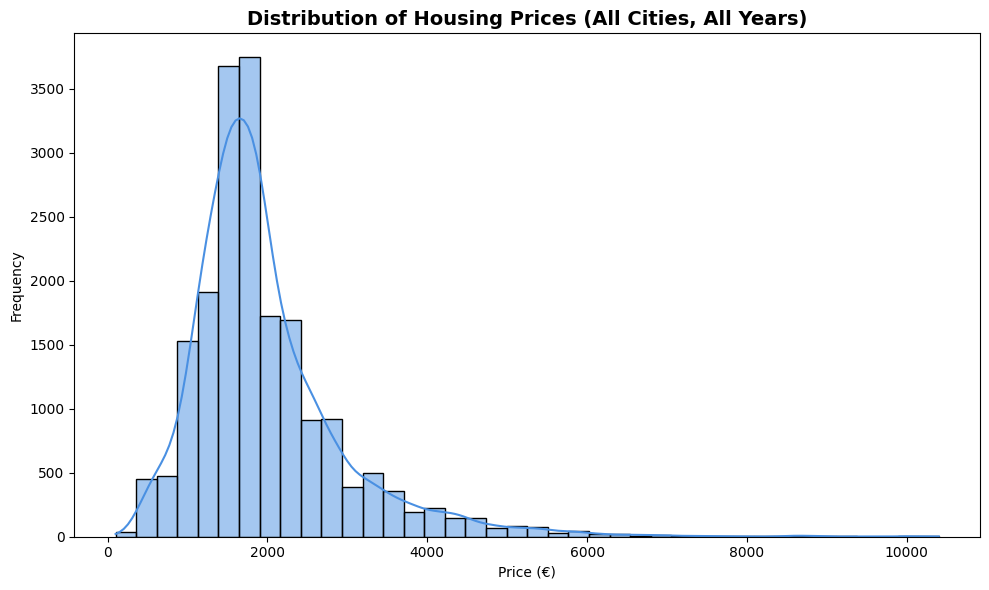

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(df_clean["Price"], bins=40, kde=True, color="#4A90E2")
plt.title("Distribution of Housing Prices (All Cities, All Years)", fontsize=14, fontweight="bold")
plt.xlabel("Price (€)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### Price Distribution Across Property Types
Housing markets can differ significantly by property type. Let's explore how apartments, single-family, and multi-family houses are priced.

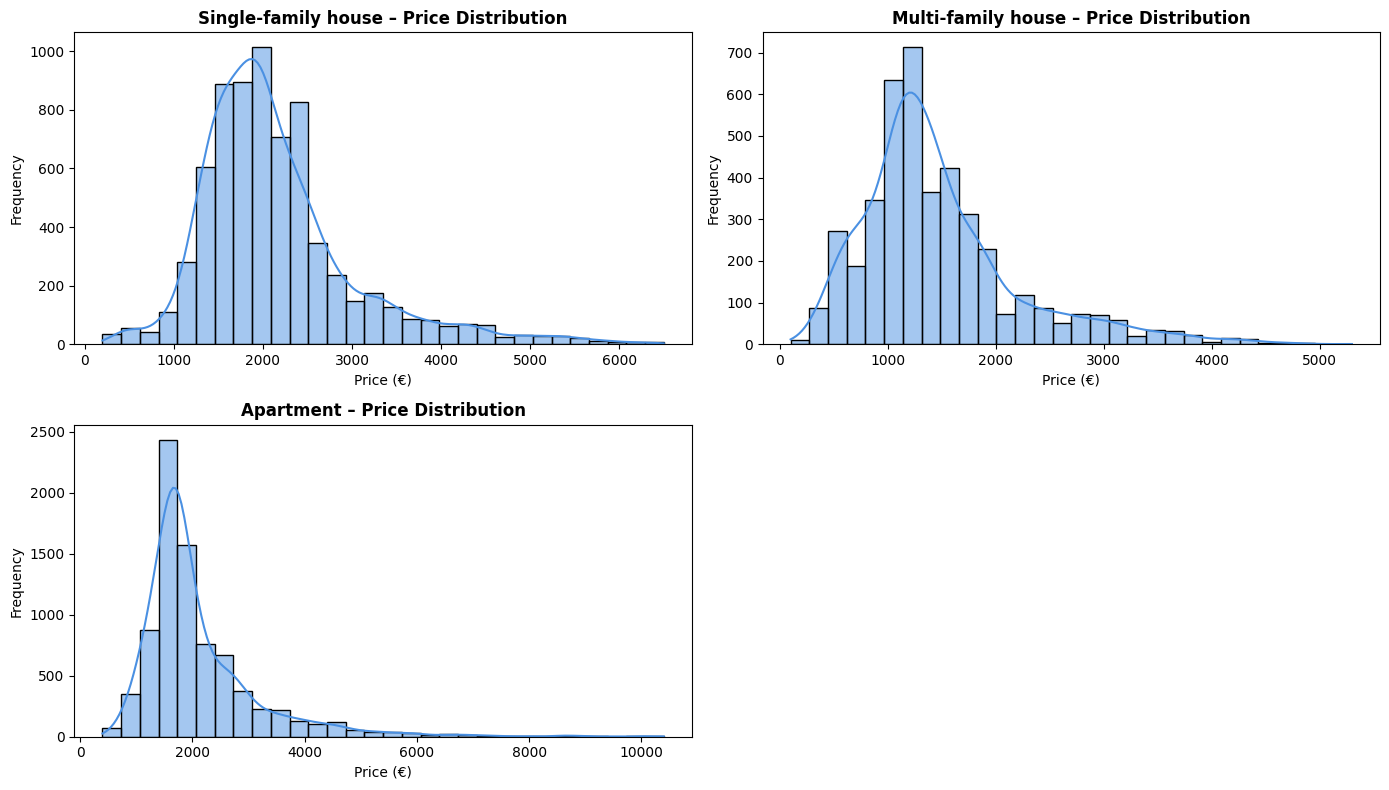

In [23]:
property_types = df_clean["Property_Type"].unique()

plt.figure(figsize=(14, 8))

for i, ptype in enumerate(property_types, 1):
    plt.subplot(2, 2, i)  
    subset = df_clean[df_clean["Property_Type"] == ptype]
    sns.histplot(subset["Price"], bins=30, kde=True, color="#4A90E2")
    plt.title(f"{ptype} – Price Distribution", fontsize=12, fontweight="bold")
    plt.xlabel("Price (€)")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

### Data Aggregation

**Decision**: We focus on **annual average prices** because:  
✓ 'Index' values are relative, not absolute  
✓ Our storytelling approach is **year-based**  
✓ Annual granularity captures macro trends while smoothing noise

In [24]:
# Aggregate Data by Year, City, and Property Type


yearly_prices = (
    df_clean.groupby(["Year", "City", "Property_Type"], as_index=False)
            .agg({
                "Price": "mean",
                "Inflation": "mean"
            })
)

# Verify 

print("Shape of yearly dataset:", yearly_prices.shape)
display(yearly_prices.head(10))

Shape of yearly dataset: (2422, 5)


,Year,City,Property_Type,Price,Inflation
0,1963,Hamburg,Single-family house,720.0,0.5
1,1964,Hamburg,Apartment,800.0,0.5
2,1964,Hamburg,Multi-family house,800.0,0.5
3,1964,Hamburg,Single-family house,790.0,0.5
4,1965,GREIX,Apartment,850.0,0.5
5,1965,GREIX,Multi-family house,250.0,0.5
6,1965,GREIX,Single-family house,850.0,0.5
7,1965,Hamburg,Apartment,500.0,0.5
8,1965,Hamburg,Multi-family house,500.0,0.5
9,1965,Hamburg,Single-family house,900.0,0.5


---
# Regional Price Trends & Comparisons

## Housing Price Trends Across German Cities (1965–2025)
How do individual cities compare to the national average over six decades?

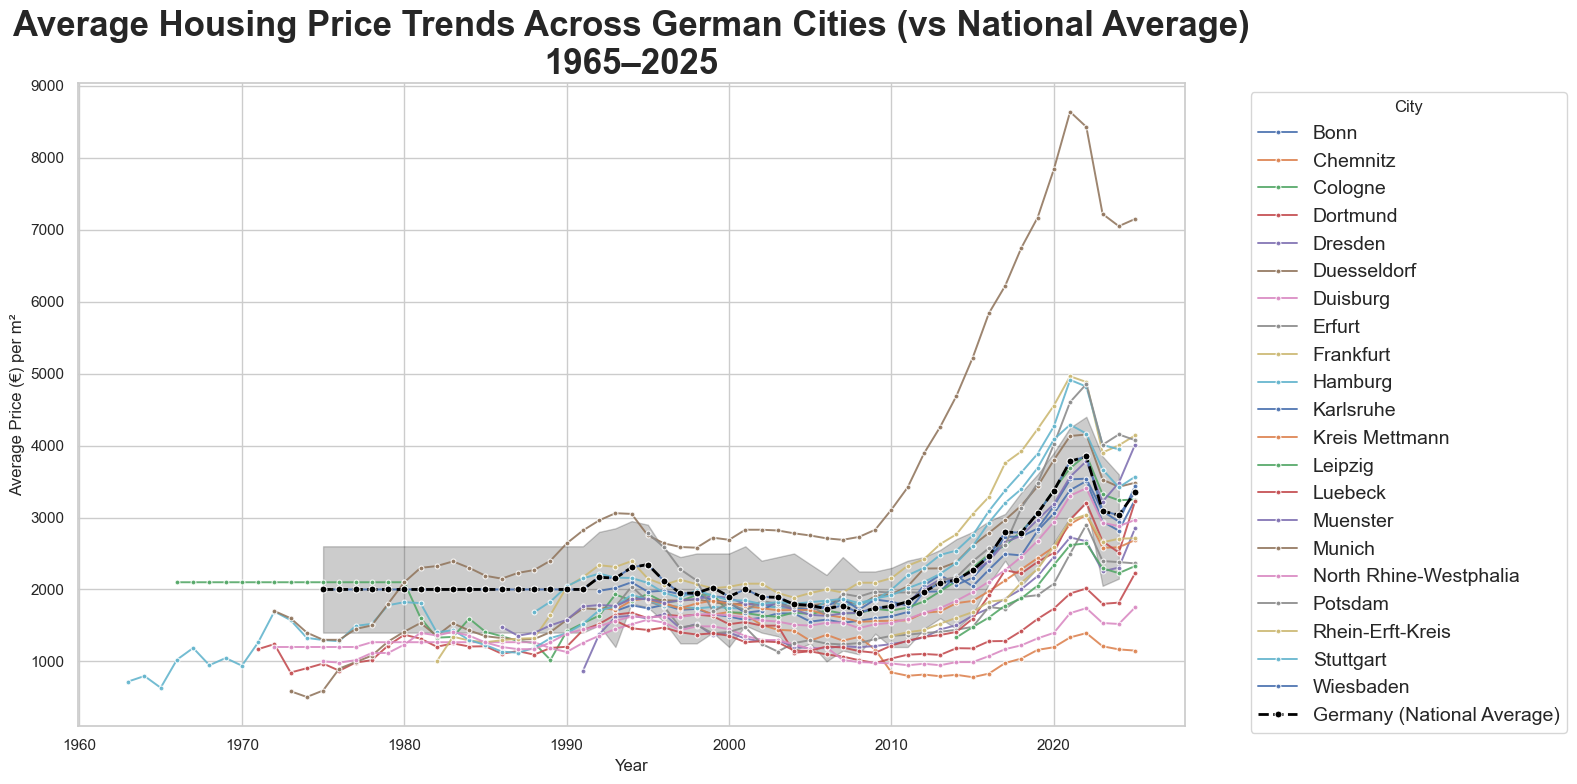

In [26]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(16, 8))

for city in sorted(yearly_prices["City"].unique()):
    if city == "GREIX":
        continue

    df_city = yearly_prices[yearly_prices["City"] == city]
    sns.lineplot(
        data=df_city,
        x="Year",
        y="Price",
        marker="o",
        markersize=3.5,
        linewidth=1.4,
        alpha=0.9,
        errorbar=None,
        label=city,
    )

if not df_city.empty:
    sns.lineplot(
        data=df_city,
        x="Year",
        y="Price",
        marker="o",
        color="black",
        linestyle="--",
        linewidth=2,
        markersize=5,
        label="Germany (National Average)",
    )

plt.title(
    "Average Housing Price Trends Across German Cities (vs National Average)\n1965-2025",
    fontsize=25,
    fontweight="bold",
)
plt.xlabel("Year")
plt.ylabel("Average Price (€) per m²")
plt.legend(title="City", bbox_to_anchor=(1.05, 1),fontsize=14, loc="upper left")
plt.tight_layout()
plt.show()

## Key Insight: The Great Divergence

**After 2010**, the German housing market fundamentally shifted:

| Period | Pattern |
|--------|---------|
| **1965–2010** | 🟢 Cities move **together** (convergence) |
| **2010–2025** | 🔴 Cities move **apart** (divergence) |

**Winners**: Munich, Frankfurt, Hamburg, and other large metros surge above national average  
**Laggards**: Smaller cities stagnate or decline relative to GREIX

## Top Performers: Cities Above the National Average
Which cities consistently outpace Germany's housing market?

C:\Users\Mustafa Ansari\AppData\Local\Temp\ipykernel_55640\2080938060.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["Price"] - x["GREIX_Avg"]).mean())


Top 3 cities above national average: ['Munich', 'Frankfurt', 'Potsdam']


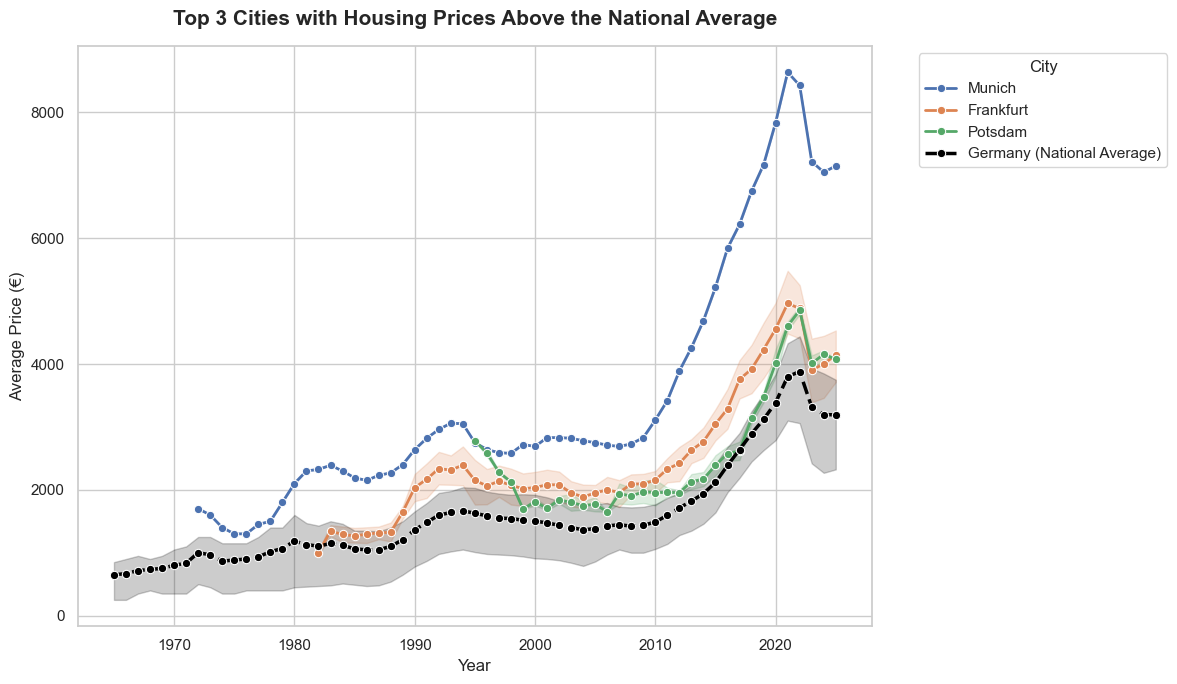

In [27]:

# Compute the national average 
df_greix = yearly_prices[yearly_prices["City"] == "GREIX"][["Year", "Price"]].rename(columns={"Price": "GREIX_Avg"})

# Merge national average 
df_compare = yearly_prices.merge(df_greix, on="Year", how="left")

# Calculate how much each city exceeds the national average
city_mean_diff = (
    df_compare.groupby("City")
    .apply(lambda x: (x["Price"] - x["GREIX_Avg"]).mean())
    .sort_values(ascending=False)
)

# Top 3 cities 
top_cities = city_mean_diff.head(3).index.tolist()
print("Top 3 cities above national average:", top_cities)

# Filter dataset 
df_top = df_compare[df_compare["City"].isin(top_cities)]

# Plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

# Plot top 3 cities
for city in top_cities:
    subset = df_top[df_top["City"] == city]
    sns.lineplot(
        data=subset,
        x="Year",
        y="Price",
        marker="o",
        linewidth=2,
        label=city
    )

# Plot national average for comparison
sns.lineplot(
    data=df_greix,
    x="Year",
    y="GREIX_Avg",
    color="black",
    linestyle="--",
    linewidth=2.5,
    marker="o",
    label="Germany (National Average)"
)

# Titles and labels
plt.title("Top 3 Cities with Housing Prices Above the National Average",
          fontsize=15, fontweight="bold", pad=15)
plt.xlabel("Year")
plt.ylabel("Average Price (€)")
plt.legend(title="City", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Underperformers: Cities Below the National Average
Where has housing growth lagged behind the national average?

C:\Users\Mustafa Ansari\AppData\Local\Temp\ipykernel_55640\2363045322.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["Price"] - x["GREIX_Avg"]).mean())


Bottom 3 cities below national average: ['Leipzig', 'Chemnitz', 'Rhein-Erft-Kreis']


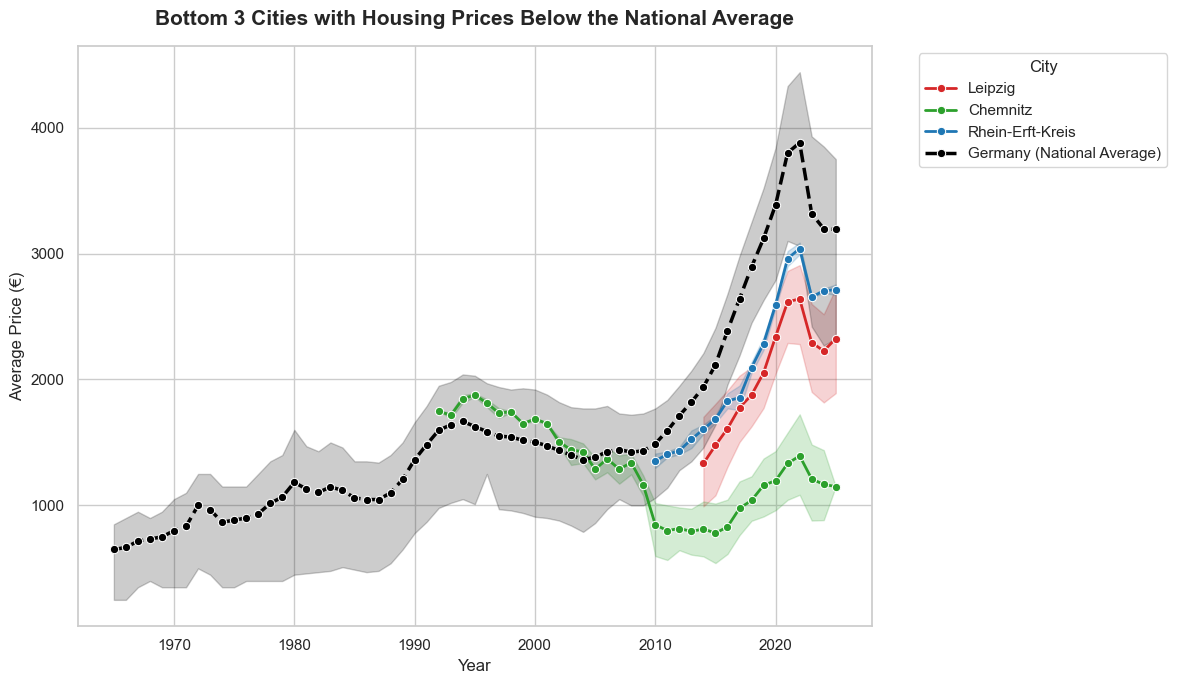

In [28]:
# Compute national average 
df_greix = yearly_prices[yearly_prices["City"] == "GREIX"][["Year", "Price"]].rename(columns={"Price": "GREIX_Avg"})

# Merge with city-level data
df_compare = yearly_prices.merge(df_greix, on="Year", how="left")

# Calculate mean difference 
city_mean_diff = (
    df_compare.groupby("City")
    .apply(lambda x: (x["Price"] - x["GREIX_Avg"]).mean())
    .sort_values(ascending=True)
)

# Select bottom 3 cities 
bottom_cities = city_mean_diff.head(3).index.tolist()
print("Bottom 3 cities below national average:", bottom_cities)

# Filter data 
df_bottom = df_compare[df_compare["City"].isin(bottom_cities)]

# Define consistent colors 
city_palette_bottom = {
    bottom_cities[0]: "#d62728",  
    bottom_cities[1]: "#2ca02c",  
    bottom_cities[2]: "#1f77b4",  
    "Germany (National Average)": "black"
}

# Plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

# Plot bottom 3 cities
for city in bottom_cities:
    subset = df_bottom[df_bottom["City"] == city]
    sns.lineplot(
        data=subset,
        x="Year",
        y="Price",
        marker="o",
        linewidth=2,
        label=city,
        color=city_palette_bottom[city]
    )

# Add national average
sns.lineplot(
    data=df_greix,
    x="Year",
    y="GREIX_Avg",
    color="black",
    linestyle="--",
    linewidth=2.5,
    marker="o",
    label="Germany (National Average)"
)

# Titles and labels
plt.title("Bottom 3 Cities with Housing Prices Below the National Average",
          fontsize=15, fontweight="bold", pad=15)
plt.xlabel("Year")
plt.ylabel("Average Price (€)")
plt.legend(title="City", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


## City-Level Deep Dive: Individual Price Trajectories (1965-2025)
Each city tells its own story. Here, we examine individual trajectories while showing the broader German context.

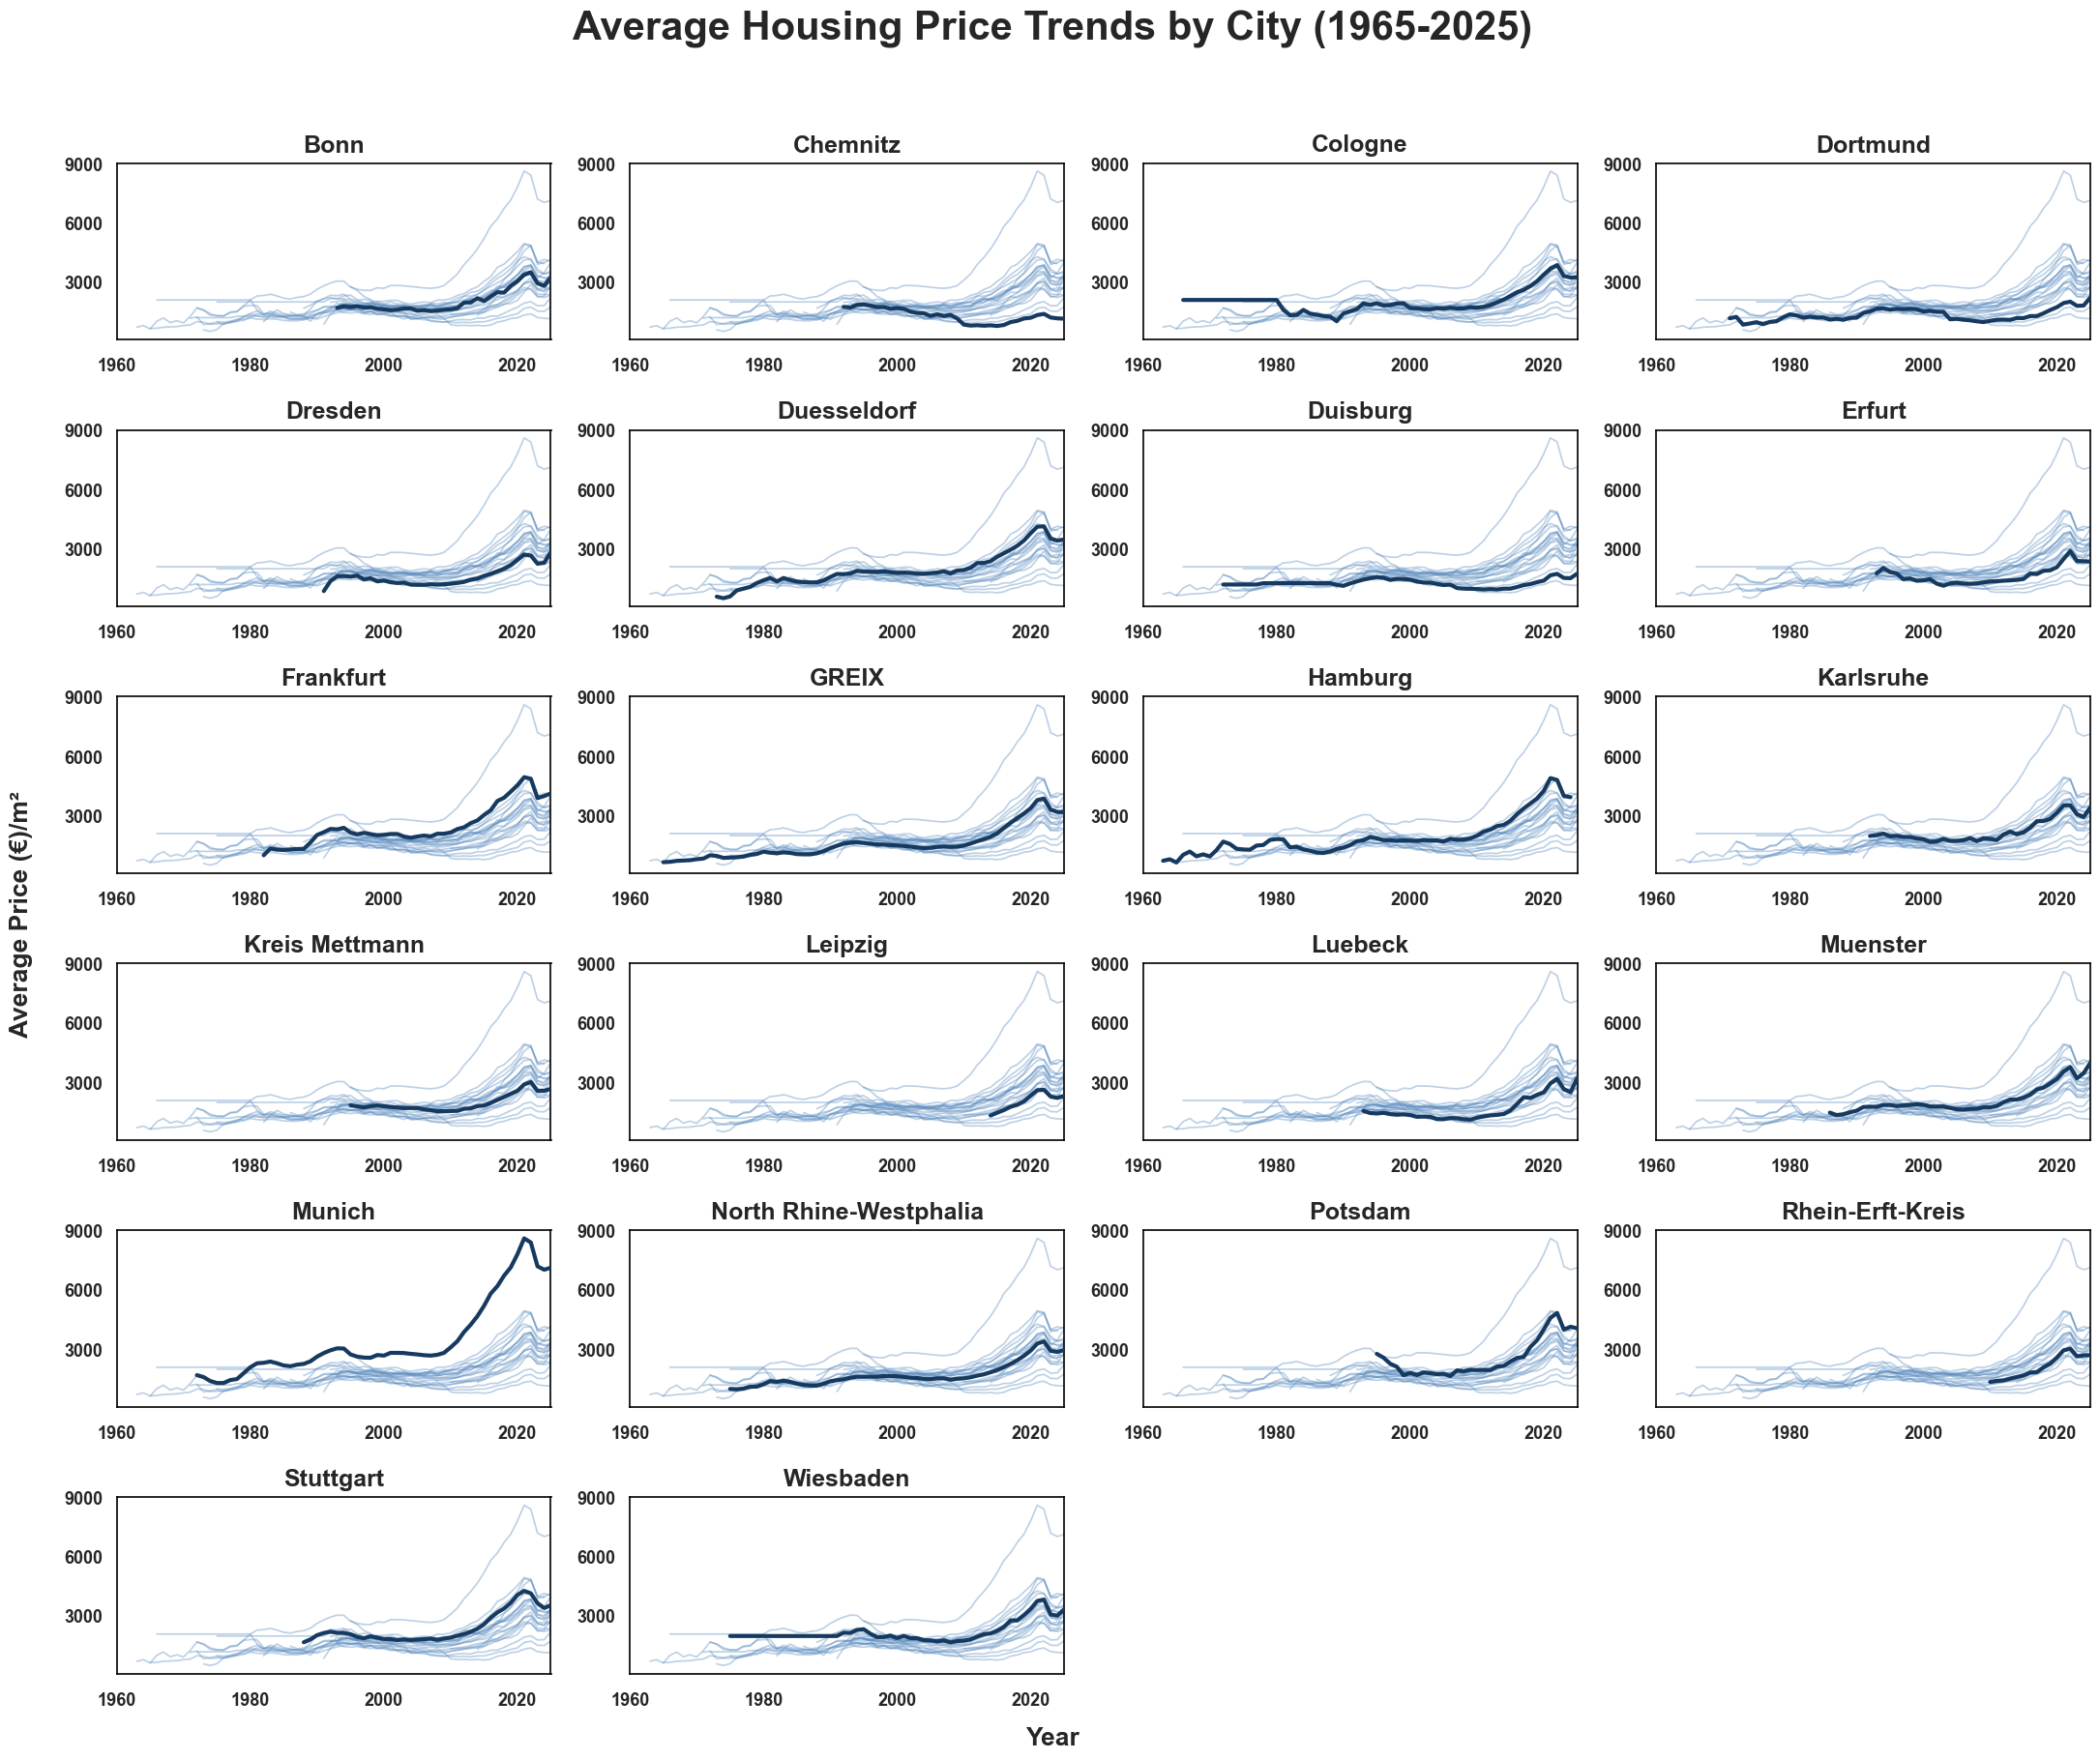

In [32]:
sns.set_theme(style="white", context="talk")

yearly_city = (
    yearly_prices
    .groupby(["City", "Year"], as_index=False)["Price"]
    .mean()
    .sort_values(["City", "Year"])
    .reset_index(drop=True)
)

cities = sorted(yearly_city["City"].unique())
x_major = [1960, 1980, 2000, 2020]
x_min, x_max = 1960, 2025

context_color = "#5b8cc0"
focus_color = "#163a5f"

ncols = 4
nrows = int(np.ceil(len(cities) / ncols))

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(22, max(7, nrows * 3.0)),
    sharex=False,
    sharey=False
)
axes = np.array(axes).reshape(-1)

context_lw = 1.25
context_alpha = 0.40

title_fs = 18
title_fw = "bold"
tick_fs = 13
tick_fw = "bold"
axis_label_fs = 19
axis_label_fw = "bold"

groups = list(yearly_city.groupby("City"))

for i, city in enumerate(cities):
    ax = axes[i]
    for _, grp in groups:
        ax.plot(grp["Year"], grp["Price"], color=context_color, lw=context_lw, alpha=context_alpha, zorder=1)
    sub = yearly_city[yearly_city["City"] == city]
    ax.plot(sub["Year"], sub["Price"], color=focus_color, lw=3.0, alpha=1.0, zorder=3)
    ax.set_title(city, fontsize=title_fs, fontweight=title_fw, pad=8)
    ax.set_xlim(x_min, x_max)
    ax.set_xticks(x_major)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.tick_params(axis="x", which="major", labelsize=tick_fs, length=8, width=1.2, pad=6)
    ax.tick_params(axis="x", which="minor", length=4, width=1.0)
    ax.tick_params(axis="y", which="major", labelsize=tick_fs, length=7, width=1.1)
    for lab in ax.get_xticklabels() + ax.get_yticklabels():
        lab.set_fontweight(tick_fw)
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(True)
        ax.spines[side].set_linewidth(1.2)
        ax.spines[side].set_color("black")
    ax.grid(False)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Average Housing Price Trends by City (1965-2025)", fontsize=30, fontweight="bold", y=1.02)
fig.supxlabel("Year", fontsize=axis_label_fs, fontweight=axis_label_fw, y=0.02)
fig.supylabel("Average Price (€)/m²", fontsize=axis_label_fs, fontweight=axis_label_fw, x=0.01)
plt.tight_layout()
plt.show()

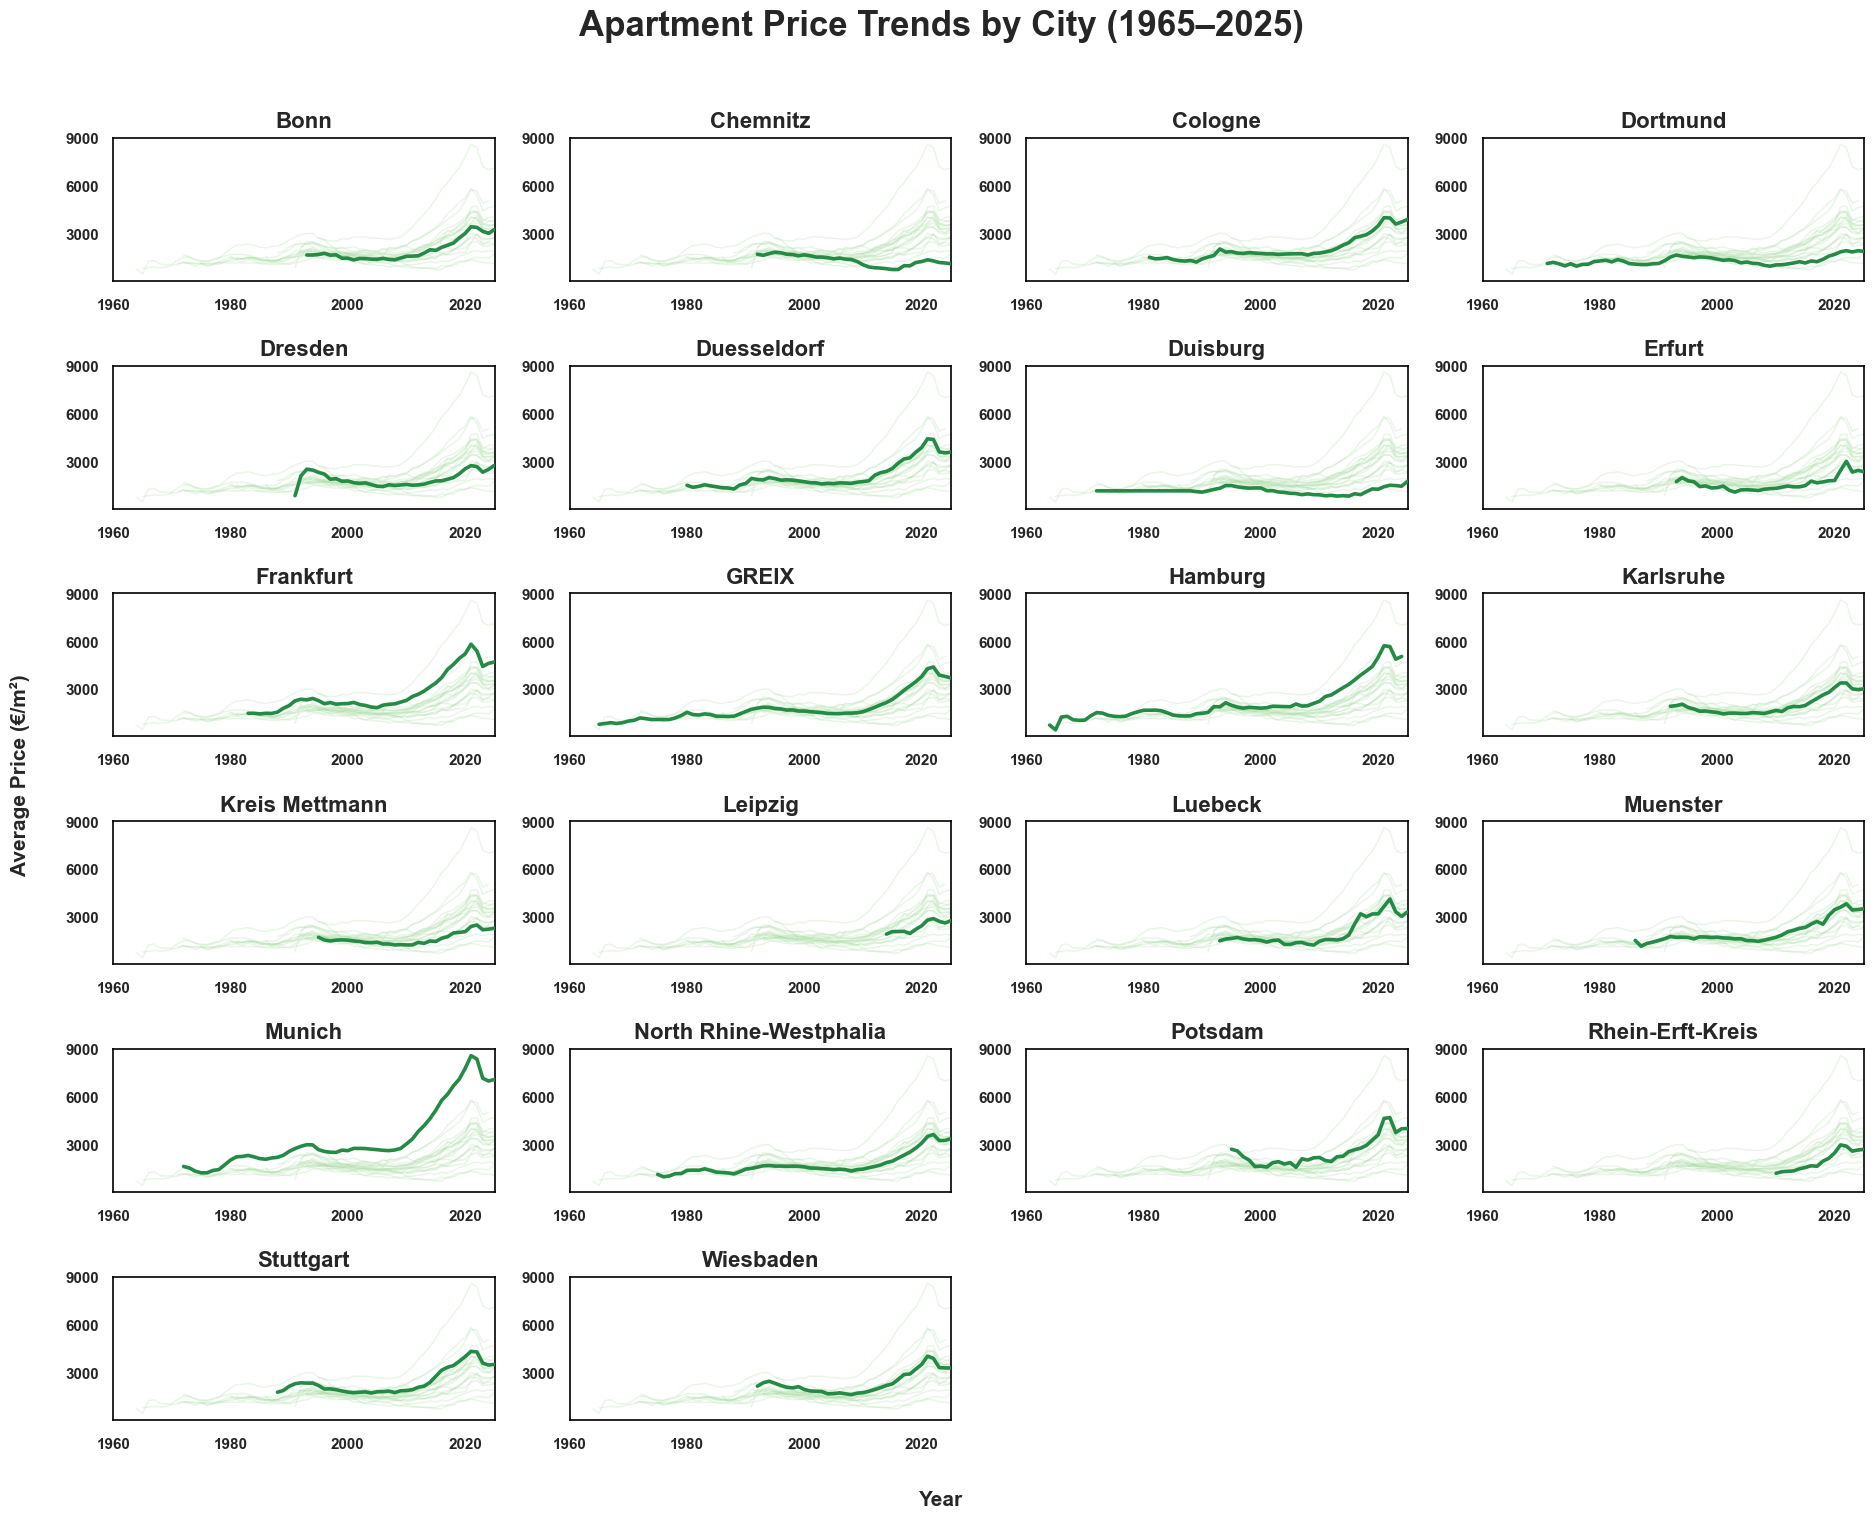

In [50]:
def plot_city_facets(yearly_prices, segment, context_color, focus_color, title, ncols=4):
    df = yearly_prices[yearly_prices["Property_Type"].str.strip() == segment].copy()
    df = (
        df.groupby(["City", "Year"], as_index=False)["Price"]
        .mean()
        .sort_values(["City", "Year"])
        .reset_index(drop=True)
    )
    cities = sorted(df["City"].unique())
    x_major = [1960, 1980, 2000, 2020]
    x_min, x_max = 1960, 2025

    nrows = int(np.ceil(len(cities) / ncols))
    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(19, 15),
        sharex=False,
        sharey=False
    )
    axes = np.array(axes).reshape(-1)

    context_lw = 1.1
    context_alpha = 0.23

    title_fs = 16
    title_fw = "bold"
    tick_fs = 11
    tick_fw = "bold"
    axis_label_fs = 15
    axis_label_fw = "bold"

    groups = list(df.groupby("City"))
    for i, city in enumerate(cities):
        ax = axes[i]
        for _, grp in groups:
            ax.plot(
                grp["Year"], grp["Price"],
                color=context_color,
                lw=context_lw,
                alpha=context_alpha,
                zorder=1
            )
        sub = df[df["City"] == city]
        ax.plot(
            sub["Year"], sub["Price"],
            color=focus_color,
            lw=2.6,
            alpha=1.0,
            zorder=3
        )
        ax.set_title(city, fontsize=title_fs, fontweight=title_fw, pad=7)
        ax.set_xlim(x_min, x_max)
        ax.set_xticks(x_major)
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
        ax.tick_params(axis="x", which="major", labelsize=tick_fs, length=8, width=1.2, pad=5)
        ax.tick_params(axis="x", which="minor", length=4, width=1.0)
        ax.tick_params(axis="y", which="major", labelsize=tick_fs, length=7, width=1.1)
        for lab in ax.get_xticklabels() + ax.get_yticklabels():
            lab.set_fontweight(tick_fw)
        for side in ["top", "right", "bottom", "left"]:
            ax.spines[side].set_visible(True)
            ax.spines[side].set_linewidth(1.2)
            ax.spines[side].set_color("black")
        ax.grid(False)
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    fig.suptitle(title, fontsize=25, fontweight="bold", y=1.01)
    fig.supxlabel("Year", fontsize=axis_label_fs, fontweight=axis_label_fw, y=0.01)
    fig.supylabel("Average Price (€/m²)", fontsize=axis_label_fs, fontweight=axis_label_fw, x=0.01)
    plt.tight_layout()
    plt.show()


plot_city_facets(
    yearly_prices,
    segment="Apartment",
    context_color="#a1d99b",
    focus_color="#238b45",
    title="Apartment Price Trends by City (1965–2025)"
)

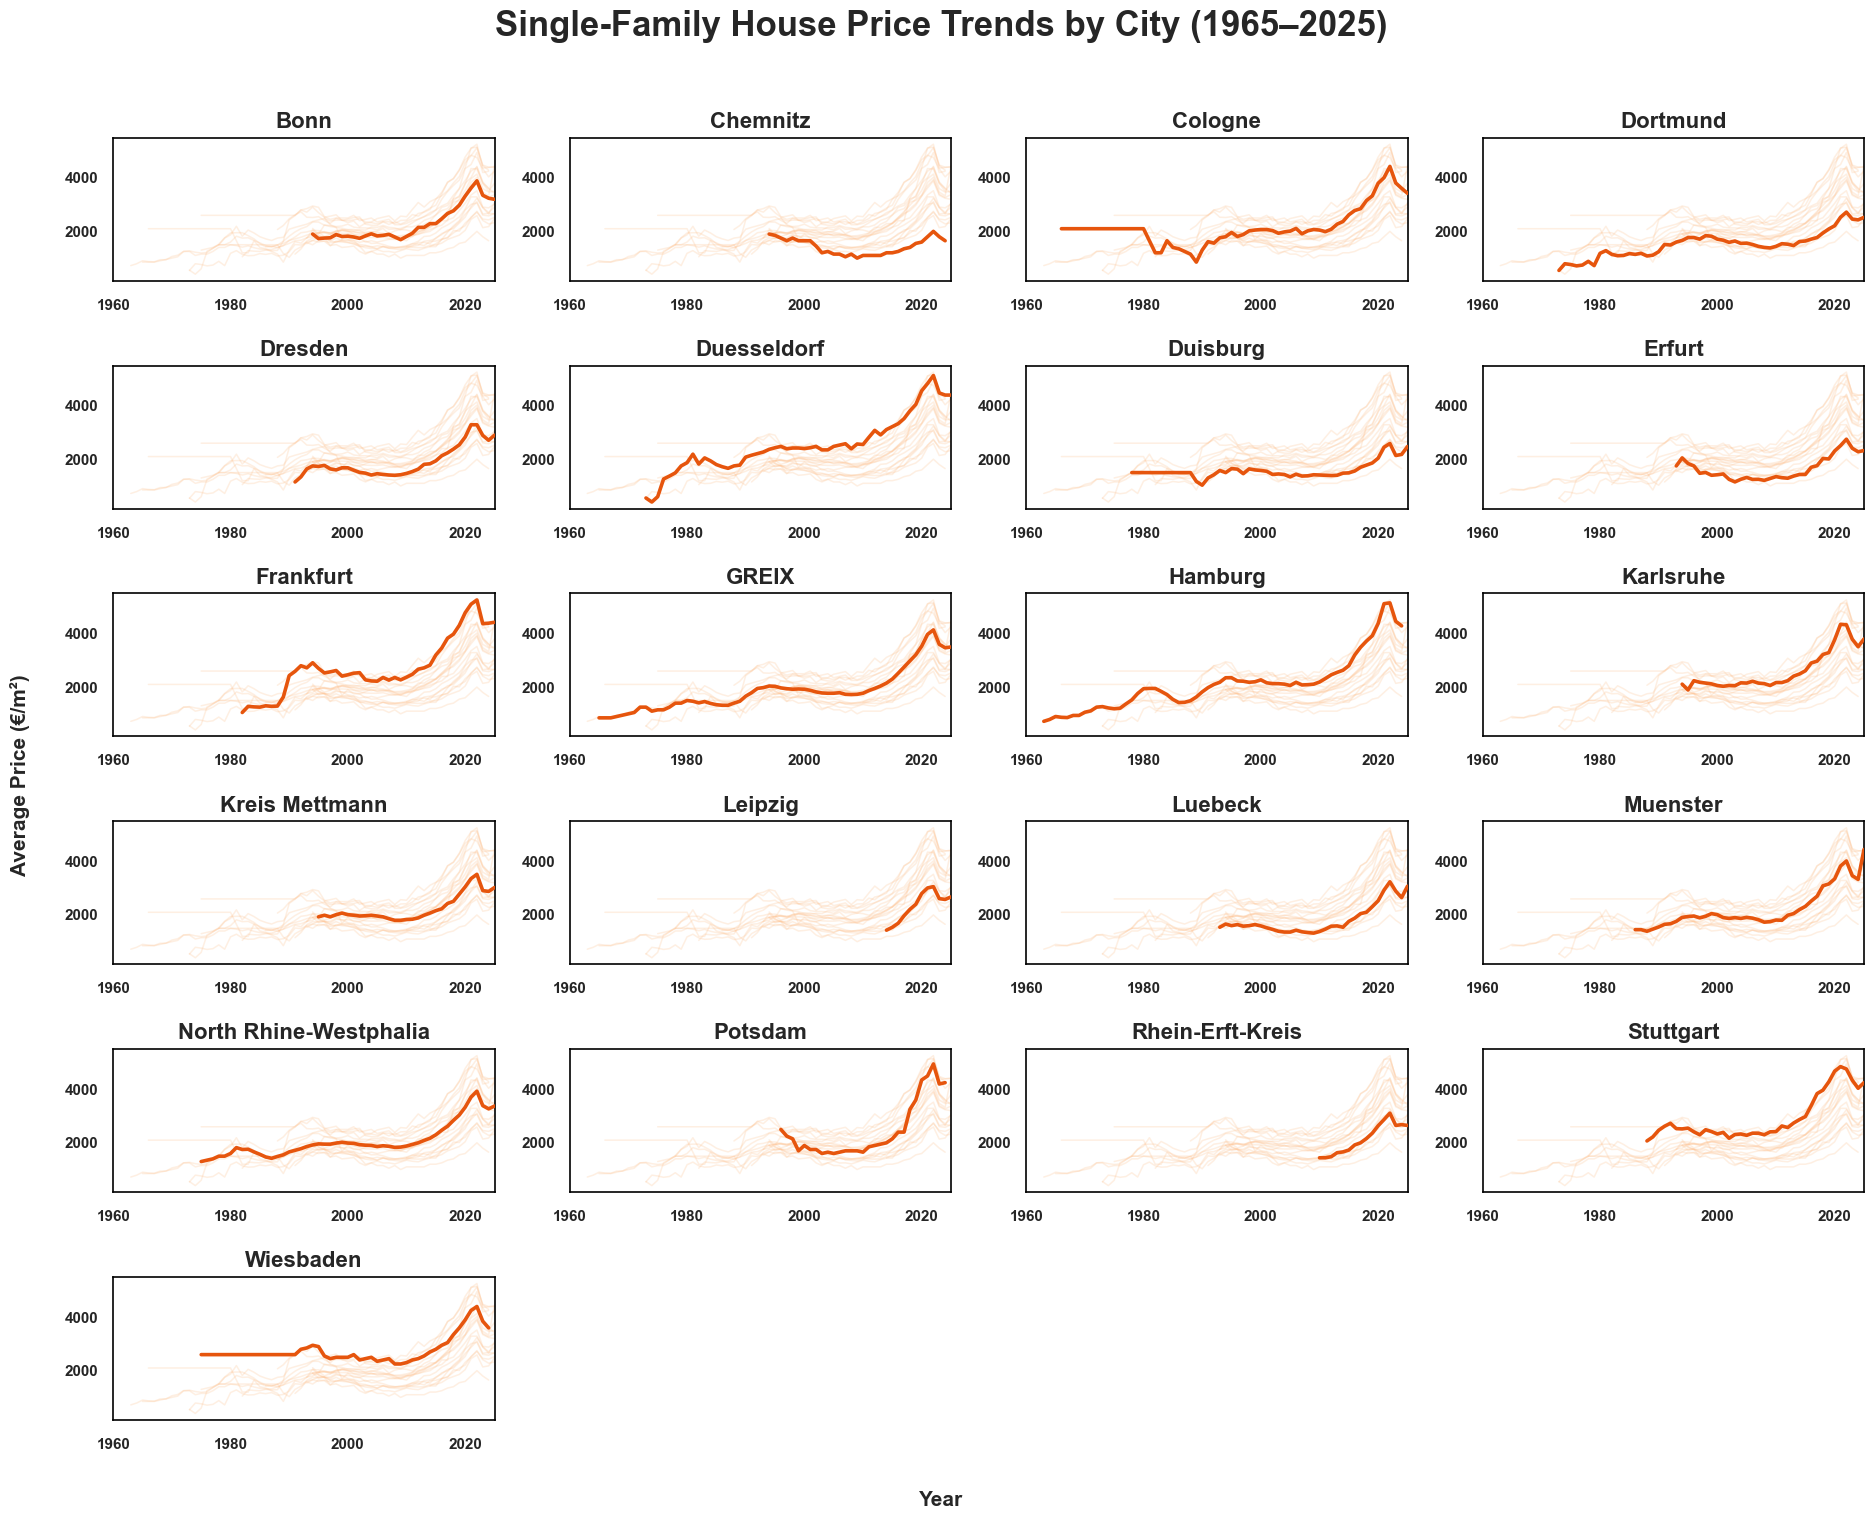

In [35]:
plot_city_facets(
yearly_prices,
    segment="Single-family house",
    context_color="#fdbb84",
    focus_color="#e6550d",
    title="Single-Family House Price Trends by City (1965-2025)"
)

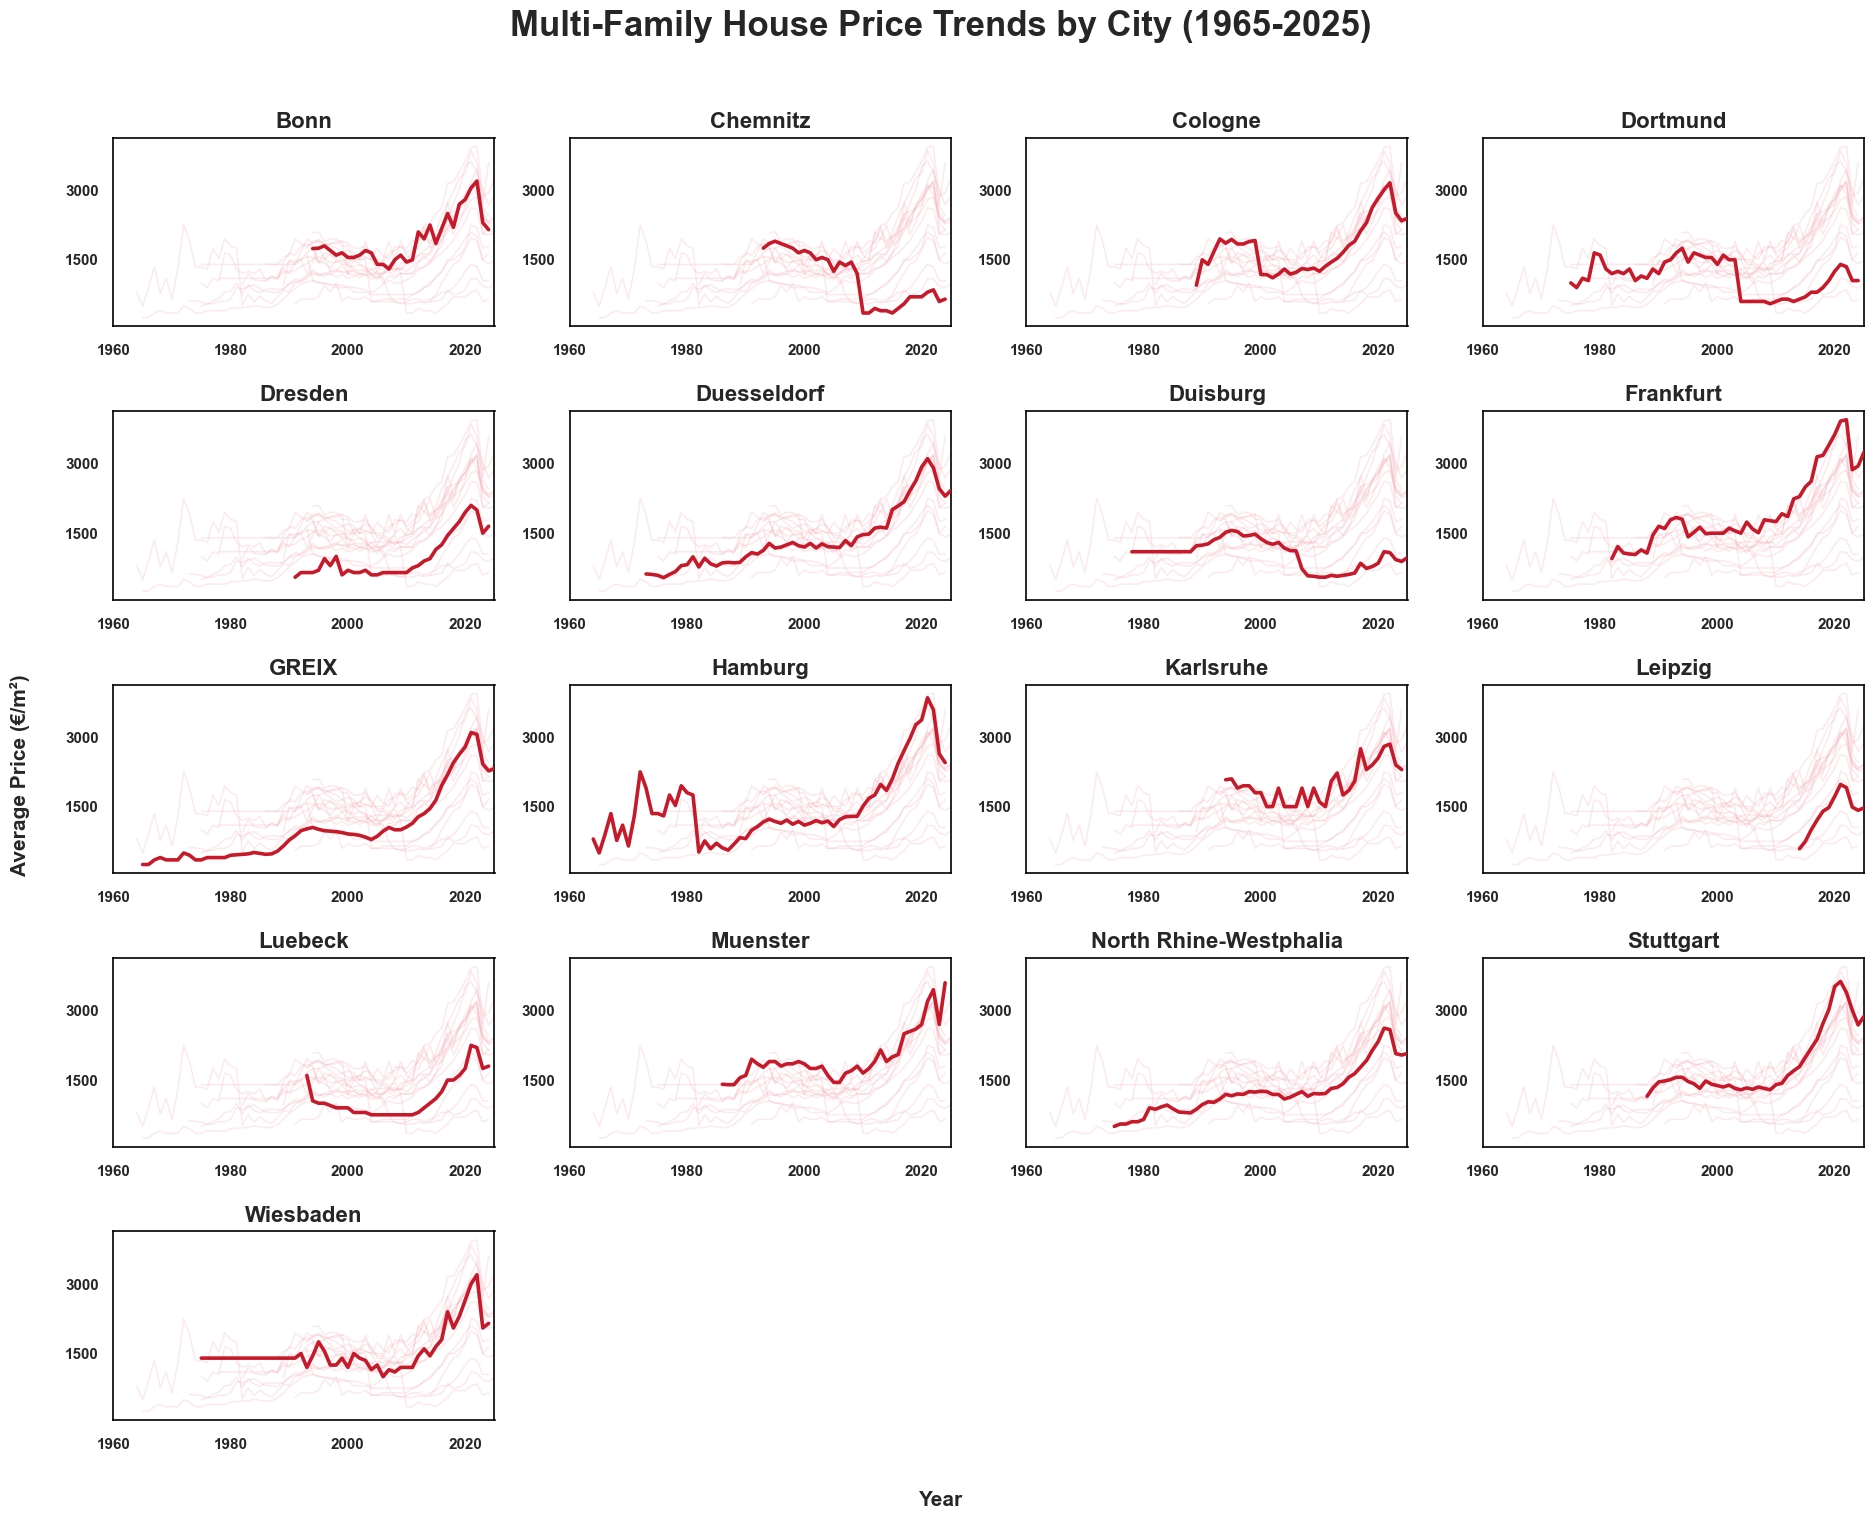

In [36]:
plot_city_facets(
    yearly_prices,
    segment="Multi-family house",
    context_color="#f3a4ae",
    focus_color="#c61a2b",
    title="Multi-Family House Price Trends by City (1965-2025)"
)

---
# Growth Analysis: Shifting Winners Over Time

## Housing Price Growth by City: Top & Bottom Performers (2004-2024)
Do the same cities win in every decade? Let's compare two distinct periods.

### Period Comparison

**Period 1: 2004–2014** (Post-crisis boom)  
**Period 2: 2014–2024** (Post-correction recovery)

Comparing these distinct decades reveals how **market dynamics shift** and which cities emerge as new leaders.

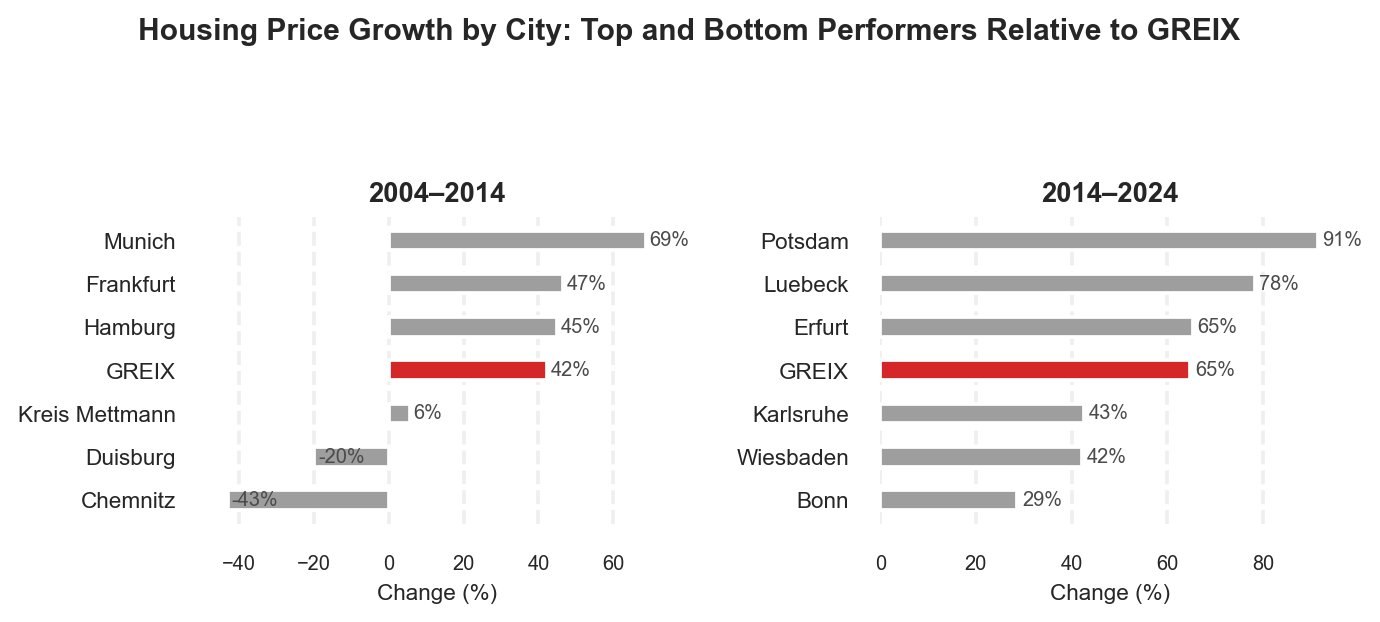

In [33]:
city_year = (
    yearly_prices
    .groupby(["City", "Year"], as_index=False)["Price"]
    .mean()
    .dropna(subset=["City", "Year", "Price"])
)

city_year["Year"] = pd.to_numeric(city_year["Year"], errors="coerce").astype(int)

wide = (
    city_year[city_year["Year"].isin([2004, 2014, 2024])]
    .pivot(index="City", columns="Year", values="Price")
)

pct_table = pd.DataFrame(index=wide.index)
pct_table["Pct_2004_2014"] = (wide[2014] / wide[2004] - 1) * 100
pct_table["Pct_2014_2024"] = (wide[2024] / wide[2014] - 1) * 100
pct_table = pct_table.dropna()

def get_top_bottom(df, col):
    g = df.loc["GREIX", col]
    d = df.drop("GREIX")

    top3 = d[d[col] > g].sort_values(col, ascending=False).head(3)
    bottom3 = d[d[col] < g].sort_values(col, ascending=False).tail(3)

    out = pd.concat([top3, df.loc[["GREIX"]], bottom3])
    return out.index.tolist(), out[col].tolist()

cities_0414, values_0414 = get_top_bottom(pct_table, "Pct_2004_2014")
cities_1424, values_1424 = get_top_bottom(pct_table, "Pct_2014_2024")

red = "#d62728"
grey = "#4b4b4b"

def plot_panel(ax, cities, values, title):
    y = np.arange(len(cities))
    colors = [red if c == "GREIX" else "#9e9e9e" for c in cities]

    ax.barh(y, values, color=colors, height=0.45)

    for i, v in enumerate(values):
        ax.text(v + 1, i, f"{v:.0f}%", va="center", fontsize=8, color=grey)

    ax.set_yticks(y)
    ax.set_yticklabels(cities, fontsize=9)
    ax.invert_yaxis()

    ax.set_title(title, fontsize=11, fontweight="bold")
    ax.set_xlabel("Change (%)", fontsize=9)
    ax.tick_params(axis="x", labelsize=8)

    ax.grid(axis="x", linestyle="--", alpha=0.3)
    for s in ax.spines.values():
        s.set_visible(False)

fig, axes = plt.subplots(1, 2, figsize=(8, 3.6), dpi=180)

plot_panel(axes[0], cities_0414, values_0414, "2004–2014")
plot_panel(axes[1], cities_1424, values_1424, "2014–2024")

fig.suptitle(
    "Housing Price Growth by City: Top and Bottom Performers Relative to GREIX",
    fontsize=12,
    fontweight="bold",
    y=0.98
)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

###  Detailed Findings

#### Period 1: 2004-2014 (Dominance of Large Metros)

- **Top Performers**
- **Munich**: Exceptional growth, far exceeding the national average
- **Frankfurt & Hamburg**: Strong performers riding economic momentum

**Bottom Performers**  
- **Duisburg & Chemnitz**: Prices declining over the decade
- **Kreis Mettmann**: Weak growth barely tracking inflation

#### Period 2: 2014–2024 (Dynamic Shift)

**New Leaders** *(Not the 2004-14 winners!)*
- **Potsdam**: Highest growth in this period (emerging metro area)
- **Lübeck & Erfurt**: Strong performers, outpacing national average

**Cooling Markets**  
- **Bonn, Wiesbaden, Karlsruhe**: Weaker growth relative to GREIX

### Key Takeaway

> **Leadership rotates**: Strong housing price growth is NOT confined to the same cities across time. Regional dynamics **shift dramatically**, suggesting emerging opportunities and risks shift between decades.

---
# Property Type Analysis: Apartments vs Houses

## National Pricing Trends by Property Type (1965-2025)
How have different housing segments evolved?

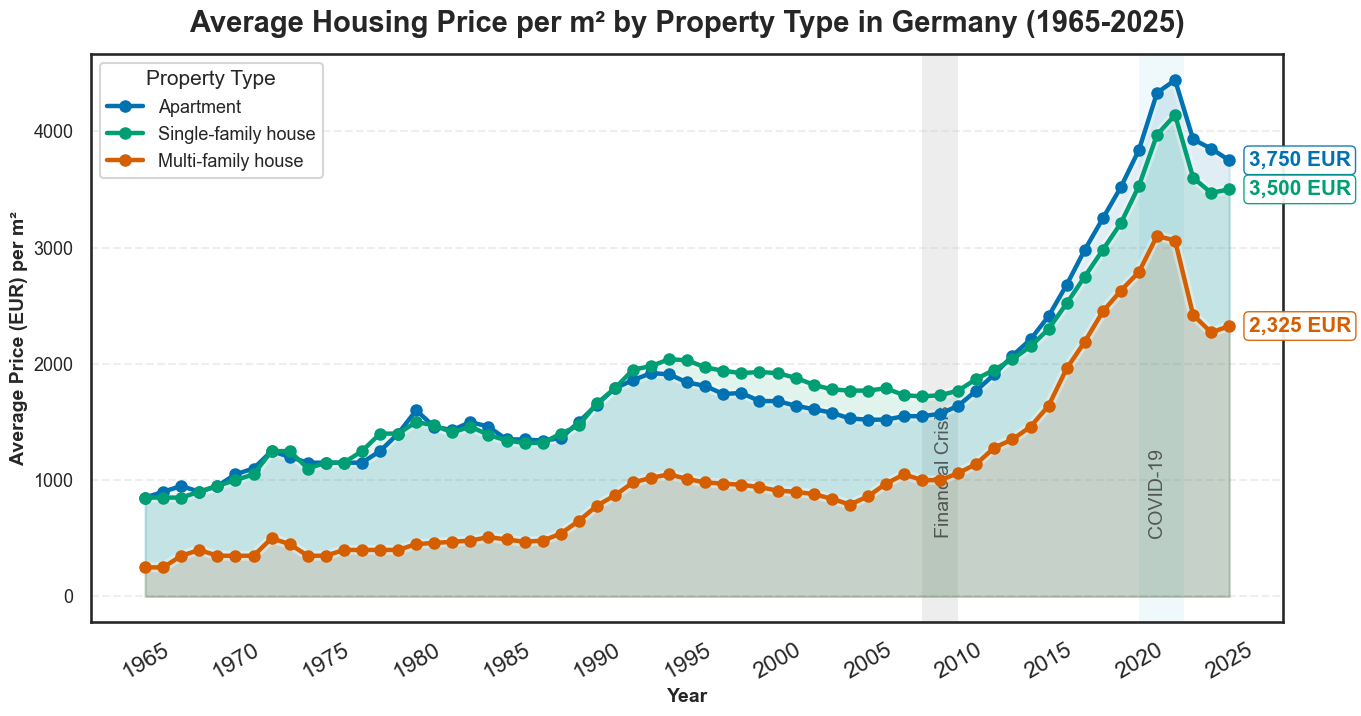

In [41]:

segment_avg = (
    yearly_prices
    .loc[yearly_prices["City"] == "GREIX", ["Year", "Property_Type", "Price"]]
    .dropna(subset=["Price"])
    .groupby(["Year", "Property_Type"], as_index=False)
    .agg(Price=("Price", "mean"))
)

type_colors = {
    "Apartment": "#0072B2",
    "Single-family house": "#009E73",
    "Multi-family house": "#D55E00"
}
outline_color = "white"
df_greix = yearly_prices[yearly_prices["City"] == "GREIX"].copy()

plt.figure(figsize=(14, 7.5))
plt.axvspan(2008, 2010, color="#bbbbbb", alpha=0.25, lw=0, zorder=0)
plt.axvspan(2020, 2022.5, color="#b0e0e6", alpha=0.20, lw=0, zorder=0)
plt.text(2008.7, 500, "Financial Crisis", rotation=90, va="bottom", fontsize=14, alpha=0.7)
plt.text(2020.5, 500, "COVID-19", rotation=90, va="bottom", fontsize=14, alpha=0.7)

for ptype, color in type_colors.items():
    d = segment_avg[segment_avg["Property_Type"] == ptype]
    plt.plot(d["Year"], d["Price"], color=outline_color, linewidth=7.2, alpha=0.35, zorder=2)
    plt.plot(d["Year"], d["Price"], color=color, linewidth=3.2, marker='o', markersize=8, zorder=3, label=ptype)
    plt.fill_between(d["Year"], d["Price"], color=color, alpha=0.12, zorder=1)
    right_year = d["Year"].max()
    right_val = d[d["Year"] == right_year]["Price"].values[0]
    plt.annotate(
        f"{int(right_val):,} EUR",
        xy=(right_year, right_val),
        xytext=(14, 0),
        textcoords="offset points",
        va="center", ha="left",
        fontsize=15, fontweight="bold", color=color,
        bbox=dict(facecolor="white", edgecolor=color, boxstyle="round,pad=0.23", lw=1, alpha=0.92)
    )

plt.title("Average Housing Price per m² by Property Type in Germany (1965-2025)", fontsize=21, fontweight="bold", pad=16)
plt.xlabel("Year", fontsize=14, fontweight="bold")
plt.ylabel("Average Price (EUR) per m²", fontsize=14, fontweight="bold")
plt.xticks(np.arange(1965, 2026, 5), rotation=30)
plt.yticks(fontsize=13)
plt.grid(axis="y", linestyle="--", alpha=0.33)
plt.legend(title="Property Type", fontsize=13, title_fontsize=15, loc="upper left")
plt.tight_layout()
plt.show()

### Analysis Summary

#### Timing: Synchronized Across Segments ✓

| Period | Pattern |
|--------|---------|
| **1965–2000** |  Moderate, steady growth |
| **2000–2010** |  Acceleration begins |
| **2010–2020** |  Strong momentum |
| **2020–2025** |  Cooling phase |



> **Insight**: Turning points affect **all segments** similarly, suggesting **macro forces** (interest rates, credit, demand) dominate over segment-specific factors.

#### Pricing: Persistent Hierarchy 

- **Highest**: Apartments & Single-family houses (especially post-2010)
- **Lowest**: Multi-family houses (but still strong growth post-2010)

> **Insight**: Price **levels** differ by type, but **growth patterns** are broadly synchronized.

## Average Annual Growth Rates by Segment (2010-2024)
Which segments grew fastest in the post-crisis recovery?

In [45]:
segments = ["Apartment", "Single-family house", "Multi-family house"]
start, end = 2010, 2024

growth_stats = []

for segment in segments:
    d = yearly_prices.copy()
    d = d[d["Property_Type"].str.strip() == segment]
    d = d[d["Year"].between(start, end)]

    p0 = d[d["Year"] == start][["City", "Price"]].rename(columns={"Price": "p_start"})
    p1 = d[d["Year"] == end][["City", "Price"]].rename(columns={"Price": "p_end"})

    df1 = p0.merge(p1, on="City", how="inner")
    df1["mean_growth"] = (np.log(df1["p_end"]) - np.log(df1["p_start"])) / (end - start) * 100
    df1["Property_Type"] = segment
    growth_stats.append(df1)

all_stats = pd.concat(growth_stats)

city_counts = all_stats["City"].value_counts()
common_cities = city_counts[city_counts == 3].index.tolist()
cities_sorted = (
    all_stats[all_stats["City"].isin(common_cities)]
    .groupby("City")["mean_growth"].mean()
    .sort_values()
    .index.tolist()
)
SEGMENT_COLORS = {
    "Apartment": "#238b45",
    "Single-family house": "#e6550d",
    "Multi-family house": "#c61a2b",
}
GREIX_HL_COLOR = "darkgray"

data_by_segment = {}
for segment in segments:
    df_seg_local = all_stats[(all_stats["Property_Type"] == segment) & (all_stats["City"].isin(cities_sorted))]
    df_seg_local = df_seg_local.sort_values("mean_growth", ascending=True).reset_index(drop=True)
    data_by_segment[segment] = df_seg_local

fig = go.Figure()

for i, segment in enumerate(segments):
    df_seg_local = data_by_segment[segment]
    colors = [GREIX_HL_COLOR if city == "GREIX" else SEGMENT_COLORS[segment] for city in df_seg_local["City"]]
    visible = True if i == 0 else False
    fig.add_trace(
        go.Bar(
            x=df_seg_local["mean_growth"],
            y=df_seg_local["City"],
            orientation='h',
            marker=dict(color=colors),
            text=[f"{v:.2f}" for v in df_seg_local["mean_growth"]],
            textposition='outside',
            name=segment,
            visible=visible,
        )
    )

buttons = []
for i, segment in enumerate(segments):
    visible = [False]*len(segments)
    visible[i] = True
    buttons.append(dict(
        method='update',
        label=segment,
        args=[{'visible': visible},
              {'title': f'Average Yearly Growth ({segment}) 2010–2024'}]
    ))

fig.update_layout(
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        x=1.0, xanchor='left',
        y=1.13, yanchor='top',
        direction="down",
        showactive=True,
        font=dict(size=15)
    )],
    title=f"Average Yearly Growth ({segments[0]}) 2010–2024",
    xaxis_title="Avg. % per year",
    yaxis_title="City",
    height=750,
    margin=dict(l=110, r=40, t=60, b=40),
    plot_bgcolor='white',
)

fig.update_traces(cliponaxis=False)
fig.show()

c:\Users\Mustafa Ansari\Downloads\German_housing\DataStorytelling-German-Housing-Prices\.venv\Lib\site-packages\kaleido\_sync_server.py:11: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




### Growth Distribution Patterns

#### Apartments: Dispersed Growth 
- **Pattern**: Strong growth in many cities, with several tracking the national benchmark
- **Outliers**: A smaller set of cities lags clearly below GREIX
- **Conclusion**: Apartment markets are **broadly distributed**, suggesting competition is widespread

#### Single-Family Houses: Compressed Growth 
- **Pattern**: More moderate overall growth, tighter city ranking
- **Conclusion**: Less extreme differences across cities; more **homogeneous** market

#### Multi-Family Houses: Reordered Rankings 
- **Pattern**: City rankings **shift completely** compared to apartments
- **Notable**: Cities strong in apartments may be weak in multi-family, and vice versa
- **Conclusion**: Segment-specific factors matter-**diversification is key**

### Investment Implication

> Different property types show **different city winners**. Investors cannot assume that Munich's apartment success translates to multi-family dominance.

## Interactive National Trend Analysis
Use the dropdown to explore each segment's evolution.

In [46]:
segments = ["Apartment", "Single-family house", "Multi-family house"]
colors = {
    "Apartment": "#238b45",
    "Single-family house": "#e6550d",
    "Multi-family house": "#c61a2b",
}

traces = []
for seg in segments:
    seg_df = segment_avg[segment_avg["Property_Type"] == seg]
    traces.append(go.Scatter(
        x=seg_df["Year"], y=seg_df["Price"],
        mode="lines+markers",
        name=seg,
        line=dict(color=colors[seg], width=3),
        marker=dict(size=7),
        visible=(seg == "Apartment")  
    ))

fig = go.Figure(traces)

def _title(seg_text):
    return dict(text=f"National Price Trend: {seg_text}", x=0.02, xanchor="left")

buttons = []
for i, seg in enumerate(segments):
    vis = [False] * len(segments)
    vis[i] = True
    buttons.append(dict(
        label=seg,
        method="update",
        args=[
            {"visible": vis},
            {"title": _title(seg)}  
        ]
    ))

buttons.append(dict(
    label="All Properties",
    method="update",
    args=[
        {"visible": [True] * len(segments)},
        {"title": _title("All property types")} 
    ]
))

fig.update_layout(
    updatemenus=[dict(
        type="dropdown",
        buttons=buttons,
        direction="down",
        x=1.01,
        y=1.0,
        xanchor="left",
        yanchor="top",
        showactive=True,
        font=dict(size=15),
    )],
    title=_title("Apartment"),
    xaxis_title="Year",
    yaxis_title="Price (€/m²)",
    legend_title_text="Property Type",
    margin=dict(t=90, l=60, r=60, b=60) 
)

fig.show()

###  Segment Performance Ranking

**Apartments & Single-Family Houses**: Strongest long-run growth, explosive post-2010  
**Multi-Family Houses**: Lagging relative growth, but still positive

> **Market Signal**: Investors favor **smaller units** (apartments) and **individual homes**. Larger multi-unit buildings may face structural headwinds (maintenance, regulatory costs, ESG pressures).

## Price Inequality: Widening Spreads Across Cities
Are prices converging or diverging? Track the ratio of most to least expensive properties.

In [47]:
def ratio_most_least(d, segment, start_year=1990, end_year=2024):
    x = d[(d["Property_Type"] == segment) & d["Price"].notna()].copy()
    x = x[(x["Year"] >= start_year) & (x["Year"] <= end_year)]
    byy = x.groupby("Year")["Price"]
    out = byy.apply(lambda s: s.max() / s.min() if s.notna().sum() >= 2 else np.nan)
    return out.dropna()

segments = ["Apartment", "Single-family house", "Multi-family house"]
colors = {
    "Apartment": "#238b45",
    "Single-family house": "#e6550d",
    "Multi-family house": "#c61a2b",
}

traces = []
for seg in segments:
    r = ratio_most_least(df, seg, start_year=1990, end_year=2024)
    traces.append(go.Scatter(
        x=r.index,
        y=r.values,
        mode="lines+markers",
        name=seg,
        line=dict(color=colors[seg], width=3),
        marker=dict(size=7),
        visible=(seg == "Apartment")  
    ))

fig = go.Figure(traces)

def _title(seg_text):
    return dict(text=f"Ratio of Most to Least Expensive: {seg_text}", x=0.02, xanchor="left")

buttons = []
for i, seg in enumerate(segments):
    vis = [False] * len(segments)
    vis[i] = True
    buttons.append(dict(
        label=seg,
        method="update",
        args=[
            {"visible": vis},
            {"title": _title(seg)}
        ]
    ))

buttons.append(dict(
    label="All Properties",
    method="update",
    args=[
        {"visible": [True] * len(segments)},
        {"title": _title("All property types")} 
    ]
))

fig.update_layout(
    updatemenus=[dict(
        type="dropdown",
        buttons=buttons,
        direction="down",
        x=1.01,
        y=1.0,
        xanchor="left",
        yanchor="top",
        showactive=True,
        font=dict(size=15),
    )],
    title=_title("Apartment"),
    xaxis_title="Year",
    yaxis_title="Max / Min price",
    legend_title_text="Property Type",
    margin=dict(t=90, l=60, r=60, b=60) 
)

fig.show()

### Key Observation

**Price inequality is WIDENING**, particularly since 2010:

- **Apartments**: Steep widening → **Munich premium soars**
- **Multi-Family**: Steady widening → **Regional gaps grow**
- **Single-Family**: More gradual → **Relatively balanced** market

> **Market Implication**: Regional arbitrage is **closing**. Price gaps are persistent and likely structural (demand, supply constraints, regulation), not temporary.

## City Price Dispersion: Quantile Bands
Visualize the full distribution of city prices using percentile bands (10th, 25th, 50th, 75th, 90th percentiles).

In [48]:
def city_dispersion_bands(d, segment, start_year=1990, end_year=2024, inflation=1, min_cities=5):
    x = d[(d["Property_Type"] == segment) & d["Price"].notna()].copy()
    x = x[(x["Year"] >= start_year) & (x["Year"] <= end_year)]

    if "Inflation" in x.columns:
        x = x[x["Inflation"] == inflation]
    if "City" in x.columns:
        x = x[~x["City"].isin(["GREIX"])]

    annual = x.groupby(["Year", "City"], as_index=False)["Price"].mean()
    wide = annual.pivot(index="Year", columns="City", values="Price").sort_index()
    wide = wide[wide.notna().sum(axis=1) >= min_cities]

    if wide.empty or wide.shape[1] == 0:
        return pd.DataFrame()

    qs = wide.quantile([0.10, 0.25, 0.50, 0.75, 0.90], axis=1, numeric_only=True).T
    qs.columns = ["p10", "p25", "p50", "p75", "p90"]
    return qs

segments = ["Apartment", "Single-family house", "Multi-family house"]
default_seg = "Apartment"

traces = []
idx_map = {}

for seg in segments:
    qs = city_dispersion_bands(df, seg, 1990, 2024, inflation=1, min_cities=5)
    idx_map[seg] = []

    if qs.empty:
        continue

    idx_map[seg].append(len(traces))
    traces.append(go.Scatter(x=qs.index, y=qs["p90"], mode="lines", line=dict(width=0),
                             showlegend=False, visible=(seg == default_seg)))
    idx_map[seg].append(len(traces))
    traces.append(go.Scatter(x=qs.index, y=qs["p10"], mode="lines", line=dict(width=0),
                             fill="tonexty", name="p10–p90 (cities)",
                             visible=(seg == default_seg)))
    idx_map[seg].append(len(traces))
    traces.append(go.Scatter(x=qs.index, y=qs["p75"], mode="lines", line=dict(width=0),
                             showlegend=False, visible=(seg == default_seg)))
    idx_map[seg].append(len(traces))
    traces.append(go.Scatter(x=qs.index, y=qs["p25"], mode="lines", line=dict(width=0),
                             fill="tonexty", name="p25–p75 (cities)",
                             visible=(seg == default_seg)))

    idx_map[seg].append(len(traces))
    traces.append(go.Scatter(x=qs.index, y=qs["p50"], mode="lines", name="Median city",
                             line=dict(width=3), visible=(seg == default_seg)))

fig = go.Figure(traces)

def _title(seg_text):
    return dict(text=f"City price dispersion bands — {seg_text}", x=0.02, xanchor="left")

buttons = []
for seg in segments:
    vis = [False] * len(traces)
    for k in idx_map.get(seg, []):
        vis[k] = True
    buttons.append(dict(
        label=seg,
        method="update",
        args=[
            {"visible": vis},
            {"title": _title(seg)}  
        ]
    ))

fig.update_layout(
    updatemenus=[dict(
        type="dropdown",
        buttons=buttons,
        direction="down",
        x=1.01,
        y=0.8,
        xanchor="left",
        yanchor="top",
        showactive=True,
        font=dict(size=15),
    )],
    title=_title(default_seg),
    xaxis_title="Year",
    yaxis_title="Price level (bands across cities)",
    margin=dict(t=90, l=60, r=60, b=60)
)

fig.show()

### How to Read This Chart

| Band | Meaning |
|------|---------|
| **p50 (median line)** | The "typical" city price each year |
| **p25–p75 (middle band)** | Where **half** of all cities fall |
| **p10–p90 (outer band)** | **90% range** of city prices |

City price dispersion bands, 1990–2024. The median (p50) shows the “typical” city each year, while the shaded ranges (p25–p75 and p10–p90) summarize how widely city prices are spread. A widening band indicates growing divergence across local markets.

---
# The Critical Question: Do Cheaper Cities Catch Up?

## Mean Reversion Analysis: Below-Median vs Above-Median Cities

In [49]:
def above_below_median_city_growth(d, segment="Apartment", start_year=2000, end_year=2024, horizon=2):
    nom = d[(d["Property_Type"] == segment) & d["Price"].notna()][["City","Year","Price"]].copy()
    real = d[(d["Property_Type"] == segment) & d["Index"].notna()][["City","Year","Index"]].copy()

    end_t = min(end_year - horizon, int(d["Year"].max()) - horizon)
    years = range(start_year, end_t + 1)

    rows = []
    for y in years:
        nom_y = nom[nom["Year"] == y].copy()
        if nom_y["City"].nunique() < 4:
            continue

        med = nom_y["Price"].median()
        nom_y["group"] = np.where(nom_y["Price"] >= med, "Above median", "Below median")

        idx_t = real[real["Year"] == y].set_index("City")["Index"]
        idx_f = real[real["Year"] == y + horizon].set_index("City")["Index"]
        g = (np.log(idx_f) - np.log(idx_t)) * 100  # log points

        tmp = nom_y.set_index("City")[["group"]].join(g.rename("growth"), how="inner").dropna()
        if tmp.empty:
            continue

        out = tmp.groupby("group")["growth"].mean()
        rows.append({"Year": y, "Above median": out.get("Above median", np.nan), "Below median": out.get("Below median", np.nan)})

    res = pd.DataFrame(rows).set_index("Year").sort_index()
    return res

res12 = above_below_median_city_growth(df, segment="Apartment", start_year=2000, end_year=2024, horizon=2)

years = res12.index.to_numpy()
x = np.arange(len(years))
w = 0.38
fig = go.Figure()
fig.add_trace(go.Bar(
    x=years, y=res12["Below median"],
    name="Below median", marker_color="#3471C1"
))
fig.add_trace(go.Bar(
    x=years, y=res12["Above median"],
    name="Above median", marker_color="#EA8C3B"
))
fig.update_layout(
    barmode="group",
    title="Avg Real 2-Year-Ahead Growth: Above vs Below Median Cities",
    xaxis_title="Year",
    yaxis_title="Avg growth over next 2 years",
    legend=dict(x=0.8, y=1.1, orientation="h")
)
fig.show()

###  What This Shows

We track **real 2-year-ahead growth** for cities grouped by whether they start above or below the median price:

| Period | Pattern | Implication |
|--------|---------|-------------|
| **2000–2010** | Below-median cities **catch up**  | Mean reversion works |
| **2010–2020** | Above-median cities **accelerate**  | Winners pull away |
| **2020–2024** | Pattern **reverses** again | Markets are dynamic |

### The Verdict

 **NO simple mean reversion**: Cheaper cities do NOT reliably catch up to expensive ones.  
**Dynamic markets**: Winners and losers rotate; market drivers are powerful and changing.  
**Timing matters**: Success requires understanding **when** the regime shifts.

> **For investors**: Buying cheap on the assumption of catch-up is risky. Regional fundamentals (jobs, amenities, transit) ultimately determine outcomes.